In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob

In [2]:
#files = glob.glob("/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/synthetic_data_pkls_HC/*.pkl")
syn_hc_files = glob.glob("/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/synthetic_data_pkls_HC/*.pkl")
syn_tle_files = glob.glob("/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/synthetic_data_pkls_TLE/*.pkl")
files = syn_hc_files[:3] + syn_tle_files[:3] 
len(files)

6

In [3]:
# img = np.load(files[3])
# plt.imshow(img[0][:,67,:], cmap='gray')

In [4]:
# Create output folder if it doesn't exist
output_folder = "/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/samples_new"
os.makedirs(output_folder, exist_ok=True)

for idx, i in enumerate(range(len(files))):
    with open(files[i],'rb') as f:
        pick = pickle.load(f)
    img = pick['image']
    label = pick['label']
    
    # Coronal slice (fixing y-axis at 69)
    cor_slice = img[:,69,:]
    rot_cor_slice = np.rot90(cor_slice, k=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_cor_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/cor_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Sagittal slice (fixing x-axis at center)
    sag_slice = img[60,:,:]
    rot_sag_slice = np.rot90(sag_slice, k=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_sag_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/sag_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
    # Axial slice (fixing z-axis at center)
    ax_slice = img[:,:,img.shape[2]//2]
    rot_ax_slice = np.rot90(ax_slice, k=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_ax_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/ax_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved 6 slices for each of the 3 axes in {output_folder}/")


Saved 6 slices for each of the 3 axes in /space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/samples_new/


In [5]:
# # Create publication-quality figure: 3 rows (axes) × 7 columns (samples)
# from matplotlib.image import imread

# fig, axes = plt.subplots(3, 7, figsize=(21, 9))
# fig.suptitle('Brain MRI Slices: Coronal, Sagittal, and Axial Views', fontsize=16, fontweight='bold', y=0.95)

# # Row labels for anatomical axes
# row_labels = ['Coronal (Synthetic)', 'Sagittal (Synthetic)', 'Axial (Synthetic)']
# axis_types = ['cor', 'sag', 'ax']

# # Create the grid
# for row in range(3):
#     for col in range(7):
#         # Load the corresponding image
#         img_path = f"{output_folder}/{axis_types[row]}_slice_{col}.png"
#         img = imread(img_path)
        
#         # Display the image
#         axes[row, col].imshow(img)
#         axes[row, col].set_xticks([])
#         axes[row, col].set_yticks([])
#         axes[row, col].set_aspect('equal')
        
#         # Add column labels (sample numbers) on top row
#         if row == 0:
#             axes[row, col].set_title(f'Sample {col+1}', fontsize=12, fontweight='bold', pad=10)
        
#         # Add row labels (anatomical views) on leftmost column
#         if col == 0:
#             axes[row, col].set_ylabel(row_labels[row], fontsize=14, fontweight='bold', rotation=90, labelpad=15)

# # Adjust layout for publication quality
# plt.tight_layout()
# plt.subplots_adjust(top=0.88, left=0.08, right=0.98, bottom=0.05, hspace=0.15, wspace=0.05)

# # Save the figure in high resolution for publication
# plt.savefig(f"{output_folder}/brain_slices_comparison.png", dpi=300, bbox_inches='tight', facecolor='white')
# #plt.savefig(f"{output_folder}/brain_slices_comparison.pdf", bbox_inches='tight', facecolor='white')

# plt.show()

# print(f"Publication-quality figure saved as:")
# print(f"  - {output_folder}/brain_slices_comparison.png (300 DPI)")
# print(f"  - {output_folder}/brain_slices_comparison.pdf (vector format)")


In [6]:
import pandas as pd
import nibabel as nib
import os
from PIL import Image

# Load CSV and filter for HC cases
output_folder = "/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/samples_new"
csv_path = "/space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/data_csvs/train.csv"
df = pd.read_csv(csv_path)
hc_cases = df[df['HC_vs_LTLE_vs_RTLE_string'] == 'HC']
rtle_cases = df[df['HC_vs_LTLE_vs_RTLE_string'] == 'right']
ltle_cases = df[df['HC_vs_LTLE_vs_RTLE_string'] == 'left']

# Get 6 files for comparison: 3 HC + 1 LTLE + 2 RTLE
hc_files = hc_cases['file'].iloc[:3].tolist()
ltle_files = ltle_cases['file'].iloc[:1].tolist()
rtle_files = rtle_cases['file'].iloc[:2].tolist()

# Combine files and create labels
all_files = hc_files + ltle_files + rtle_files
labels = ['HC'] * 3 + ['TLE'] * 3
print(f"Using {len(all_files)} files for comparison: 3 HC + 3 TLE")

# Extract and save real slices at the same positions as synthetic ones
real_slices = {'cor': [], 'sag': [], 'ax': []}

for idx, file_path in enumerate(all_files):
    label = labels[idx]
    print(f"Processing {label} file {idx+1}/6: {os.path.basename(file_path)}")
    
    # Load NIfTI file
    nii_img = nib.load(file_path)
    real_img = nii_img.get_fdata()
    real_img = (real_img - np.mean(real_img)) / np.std(real_img)  
    real_img = real_img[:, 1:137, :]

    slices = []
    for i in range(real_img.shape[1]):
        slice_img = Image.fromarray(real_img[:, i, :])
        slice_img = slice_img.resize((112, 112), Image.BILINEAR)
        slice_img = np.array(slice_img)
        slices.append(slice_img)
    real_img = np.stack(slices, axis=1)
    
    # Extract slices at same positions as synthetic ones
    # Coronal slice (y=69, but need to adjust for different image sizes)
    y_pos = min(69, real_img.shape[1]-1)
    cor_slice = real_img[:, y_pos, :]
    rot_cor_slice = np.rot90(cor_slice, k=1)
    
    # Sagittal slice (x=60, but adjust for different sizes)  
    x_pos = min(60, real_img.shape[0]-1)
    sag_slice = real_img[x_pos, :, :]
    rot_sag_slice = np.rot90(sag_slice, k=1)
    
    # Axial slice (center z)
    ax_slice = real_img[:, :, real_img.shape[2]//2]
    rot_ax_slice = np.rot90(ax_slice, k=1)
    
    # Save real slices as images
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_cor_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/real_cor_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_sag_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/real_sag_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rot_ax_slice, cmap='gray')
    plt.axis('off')
    plt.savefig(f"{output_folder}/real_ax_slice_{idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

print("Real slice images saved!")

# Create publication-quality figure: 6 rows (real vs synthetic for each axis) × 7 columns (samples)


Using 6 files for comparison: 3 HC + 3 TLE
Processing HC file 1/6: mwp1sub-MUSC0093_ses-01_T1w.nii
Processing HC file 2/6: mwp1sub-20140927121819_ses-01_T1w.nii
Processing HC file 3/6: mwp1sub-ECPEC1197_ses-1A_acq-mpragemot_run-1_T1w.nii
Processing TLE file 4/6: mwp1sub-UNAM27974_ses-01_T1w.nii
Processing TLE file 5/6: mwp1sub-PITP0022_ses-pre_T1w.nii
Processing TLE file 6/6: mwp1sub-MUSP0041_ses-pre_T1w.nii
Real slice images saved!


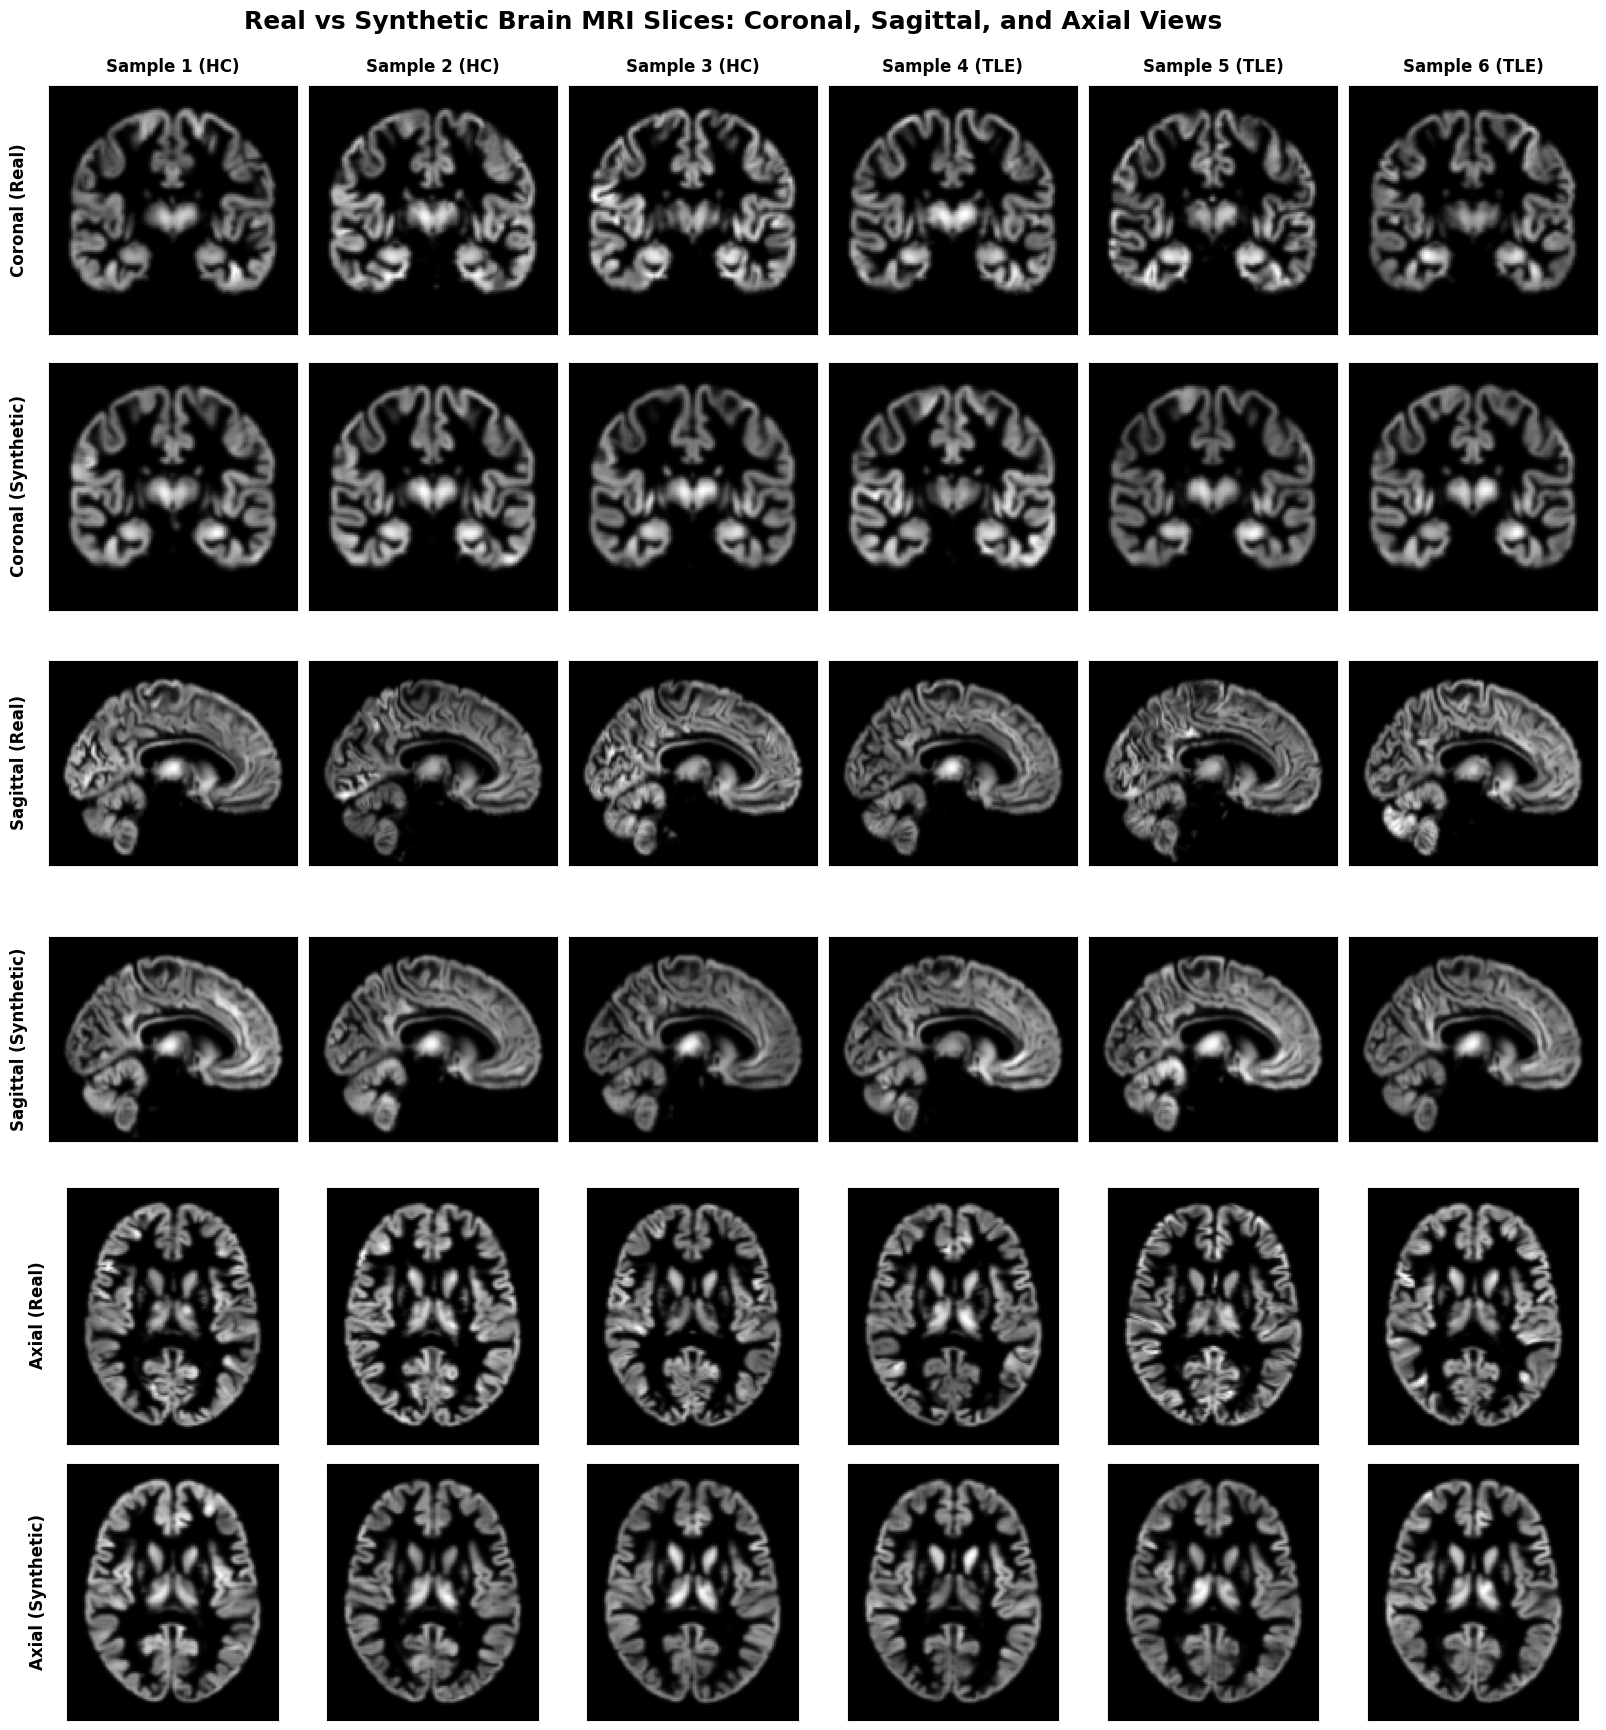

Clean comparison figure (without horizontal lines) saved as:
  - /space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/samples_new/real_vs_synthetic_comparison_clean.png (300 DPI)
  - /space/mcdonald-syn01/1/projects/jsawant/Diffusion_paper/samples_new/real_vs_synthetic_comparison_clean.pdf (vector format)


In [7]:
# Create publication-quality figure: 6 rows (real vs synthetic for each axis) × 6 columns (samples)
# WITHOUT horizontal line separators to avoid artifacts
from matplotlib.image import imread

fig, axes = plt.subplots(6, 6, figsize=(18, 18))
fig.suptitle('Real vs Synthetic Brain MRI Slices: Coronal, Sagittal, and Axial Views', 
             fontsize=18, fontweight='bold', y=0.97)

# Row labels for real vs synthetic comparison
row_labels = ['Coronal (Real)', 'Coronal (Synthetic)', 
              'Sagittal (Real)', 'Sagittal (Synthetic)',
              'Axial (Real)', 'Axial (Synthetic)']

# Image types and file prefixes
image_types = ['real_cor', 'cor', 'real_sag', 'sag', 'real_ax', 'ax']

# Sample labels (3 HC + 3 TLE)
sample_labels = ['Sample 1 (HC)', 'Sample 2 (HC)', 'Sample 3 (HC)', 'Sample 4 (TLE)', 'Sample 5 (TLE)', 'Sample 6 (TLE)']

# Create the grid
for row in range(6):
    for col in range(6):
        # Load the corresponding image
        img_path = f"{output_folder}/{image_types[row]}_slice_{col}.png"
        img = imread(img_path)
        
        # Display the image
        axes[row, col].imshow(img)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col].set_aspect('equal')
        
        # Add column labels (HC/TLE labels) on top row
        if row == 0:
            axes[row, col].set_title(sample_labels[col], fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels on leftmost column
        if col == 0:
            axes[row, col].set_ylabel(row_labels[row], fontsize=12, fontweight='bold', rotation=90, labelpad=15)

# Adjust layout for publication quality (no separating lines)
plt.tight_layout()
plt.subplots_adjust(top=0.93, left=0.12, right=0.98, bottom=0.02, hspace=0.08, wspace=0.05)

# Save the figure in high resolution for publication
plt.savefig(f"{output_folder}/real_vs_synthetic_comparison_clean.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f"{output_folder}/real_vs_synthetic_comparison_clean.pdf", bbox_inches='tight', facecolor='white')

plt.show()

print(f"Clean comparison figure (without horizontal lines) saved as:")
print(f"  - {output_folder}/real_vs_synthetic_comparison_clean.png (300 DPI)")
print(f"  - {output_folder}/real_vs_synthetic_comparison_clean.pdf (vector format)")


In [ ]:
from matplotlib.image import imread

fig, axes = plt.subplots(6, 6, figsize=(18, 18))
fig.suptitle('Real vs Synthetic Brain MRI Slices: Coronal, Sagittal, and Axial Views', 
             fontsize=18, fontweight='bold', y=0.97)

# Row labels for real vs synthetic comparison
row_labels = ['Coronal (Real)', 'Coronal (Synthetic)', 
              'Sagittal (Real)', 'Sagittal (Synthetic)',
              'Axial (Real)', 'Axial (Synthetic)']

# Image types and file prefixes
image_types = ['real_cor', 'cor', 'real_sag', 'sag', 'real_ax', 'ax']

# Sample labels (3 HC + 3 TLE)
sample_labels = ['HC 1', 'HC 2', 'HC 3', 'TLE 1', 'TLE 2', 'TLE 3']

# Create the grid
for row in range(6):
    for col in range(6):
        # Load the corresponding image
        img_path = f"{output_folder}/{image_types[row]}_slice_{col}.png"
        img = imread(img_path)
        
        # Display the image
        axes[row, col].imshow(img)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
        axes[row, col].set_aspect('equal')
        
        # Add column labels (HC/TLE labels) on top row
        if row == 0:
            axes[row, col].set_title(sample_labels[col], fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels on leftmost column
        if col == 0:
            axes[row, col].set_ylabel(row_labels[row], fontsize=12, fontweight='bold', rotation=90, labelpad=15)

# Add separating lines between real and synthetic rows
for i in [1.5, 3.5]:  # Between coronal real/synthetic, sagittal real/synthetic
    fig.add_artist(plt.Line2D([0.12, 0.98], [1 - (i+0.5)/6, 1 - (i+0.5)/6], 
                             color='gray', linewidth=0.8, transform=fig.transFigure))

# Adjust layout for publication quality
plt.tight_layout()
plt.subplots_adjust(top=0.93, left=0.12, right=0.98, bottom=0.02, hspace=0.08, wspace=0.05)

# Save the figure in high resolution for publication
plt.savefig(f"{output_folder}/real_vs_synthetic_comparison.png", dpi=300, bbox_inches='tight', facecolor='white')
#plt.savefig(f"{output_folder}/real_vs_synthetic_comparison.pdf", bbox_inches='tight', facecolor='white')

plt.show()

print(f"Real vs Synthetic comparison figure saved as:")
print(f"  - {output_folder}/real_vs_synthetic_comparison.png (300 DPI)")
print(f"  - {output_folder}/real_vs_synthetic_comparison.pdf (vector format)")
